In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from cieluv import *
from RootPolyRegression import *
%matplotlib inline

In [90]:

patch_spectras = ['Dark Skin.reflect', 'Light Skin.reflect', 'Blue Sky.reflect',
                 'Foilage.reflect', 'Blue Flower.reflect', 'Bluish Green.reflect',
                 'Orange.reflect', 'Purplish Blue.reflect', 'Moderate Red.reflect',
                 'Purple.reflect', 'Yellow Green.reflect', 'Orange Yellow.reflect',
                 'Blue.reflect', 'Green.reflect', 'Red.reflect',
                 'Yellow.reflect', 'Magenta.reflect', 'Cyan.reflect',
                 'White.reflect', 'Neutral-8.reflect', 'Neutral-6.5.reflect',
                 'Neutral-5.reflect', 'Neutral-3.5.reflect', 'Black.reflect']
#patch_spectras = ['Dark Skin.reflect', 'Light Skin.reflect', 'Blue Sky.reflect', 'Foilage.reflect', 'Blue Flower.reflect', 'Bluish Green.reflect', 'Orange.reflect']

In [11]:
#x = np.linspace(380, 780, 101)
x = np.linspace(380, 710, 34)
# D65 source
src = np.loadtxt("./d65.illum")
x_src = np.linspace(300, 830, 531)
src = np.interp(x, x_src, src)
D65 = np.diag(src)

# XYZ spectral sensitivities
f = open('camera.kinect1.json', 'r')
xyz_dict = json.load(f)
XYZ_R = np.array(xyz_dict['sensitivities']['red'])[:, 1]
XYZ_G = np.array(xyz_dict['sensitivities']['green'])[:, 1]
XYZ_B = np.array(xyz_dict['sensitivities']['blue'])[:, 1]
x_XYZ = np.linspace(365, 830, 94) 
sens_XYZ_R = np.interp(x, x_XYZ, XYZ_R)
sens_XYZ_G = np.interp(x, x_XYZ, XYZ_G)
sens_XYZ_B = np.interp(x, x_XYZ, XYZ_B)

# RGB camera sensitivities
cam_R, cam_G, cam_B = np.loadtxt("cam_R.spect"), np.loadtxt("cam_G.spect"), np.loadtxt("cam_B.spect")
x_RGB = np.linspace(380, 784, 101)
sens_RGB_R = np.interp(x, x_RGB, cam_R)
sens_RGB_G = np.interp(x, x_RGB, cam_G)
sens_RGB_B = np.interp(x, x_RGB, cam_B)


In [12]:
X_WHITE = np.dot(sens_XYZ_R.T, src)
Y_WHITE = np.dot(sens_XYZ_G.T, src)
Z_WHITE = np.dot(sens_XYZ_B.T, src)
print("White point: ", X_WHITE, Y_WHITE, Z_WHITE)
WHITE_POINT_XYZ_D65 = [X_WHITE, Y_WHITE, Z_WHITE]
WHITE_POINT_XYZ_D65 /= Y_WHITE
WHITE_POINT_XYZ_D65

White point:  1101.526205260834 1161.8233618722663 1247.688746881038


array([0.94810127, 1.        , 1.07390571])

In [93]:
colorsXYZ = []
for patch in patch_spectras:
    refl = np.loadtxt("./patches/" + patch)
    X = np.dot(np.dot(sens_XYZ_R.T, D65), refl)
    Y = np.dot(np.dot(sens_XYZ_G.T, D65), refl)
    Z = np.dot(np.dot(sens_XYZ_B.T, D65), refl)
    c = np.array([X, Y, Z]) / Y_WHITE
    colorsXYZ.append(c)
colorsXYZ = np.array(colorsXYZ)

colorsRGB = []
for patch in patch_spectras:
    refl = np.loadtxt("./patches/" + patch)
    R = np.dot(np.dot(sens_RGB_R.T, D65), refl)
    G = np.dot(np.dot(sens_RGB_G.T, D65), refl)
    B = np.dot(np.dot(sens_RGB_B.T, D65), refl)
    c = np.array([R, G, B]) / Y_WHITE
    colorsRGB.append(c)
colorsRGB = np.array(colorsRGB)

In [94]:
R = get_rp_features(colorsRGB.T, 2)
R.shape

(6, 24)

In [17]:
def LOO(Q, R, whitepoint):
    err = 0
    
    for i in range(R.shape[1]):
        
        # i-ый объект на тесте, остальные на трейне
        Q_train = np.concatenate((Q[:, :i], Q[:, (i+1):]), axis=1)
        R_train = np.concatenate((R[:, :i], R[:, (i+1):]), axis=1)
        Q_test = Q[:, i]
        R_test = R[:, i]
        
        # fitting
        A = np.dot(np.dot(Q_train, R_train.T), np.linalg.inv(np.dot(R_train, R_train.T)))
        
        # score on test object
        err += CIELUV_DeltaE_from_XYZ(np.dot(A, R_test), Q_test, whitepoint)
        
    return err / 24

In [96]:
for power in range(1, 5):
    R = get_rp_features(colorsRGB.T, power) # returns root-poly features
    Q = colorsXYZ.T
    print("power: ", power, " score: ", LOO(Q, R, WHITE_POINT_XYZ_D65))

power:  1  score:  10.018095479536143
power:  2  score:  6.0191950885795205
power:  3  score:  10.625604188799391
power:  4  score:  11199.86050068524


In [3]:
spectra = np.loadtxt("ColorCheckerSG_spectra.txt")
spectra.shape

(140, 34)

In [68]:
def get_palette(colors, size):
    h = size[0]
    l = size[1]
    if h * l != colors.shape[0]:
        raise ValueError('Length of \'colors\' must be equal to product of elements of \'size\' ')
    
    palette = np.zeros((h * 10, l * 10, 3))
    for i in range(colors.shape[0]):
        palette[(i // l * 10):((i // l + 1) * 10), (i % l * 10):((i % l +1)*10)] = colors[i]
    return palette


In [260]:
colorsXYZ = []
for i in range(spectra.shape[0]):
    refl = spectra[i]
    X = np.dot(np.dot(sens_XYZ_R.T, D65), refl)
    Y = np.dot(np.dot(sens_XYZ_G.T, D65), refl)
    Z = np.dot(np.dot(sens_XYZ_B.T, D65), refl)
    c = np.array([X, Y, Z]) / Y_WHITE
    colorsXYZ.append(c)
colorsXYZ = np.array(colorsXYZ)

colorsRGB = []
for i in range(spectra.shape[0]):
    refl = spectra[i]
    R = np.dot(np.dot(sens_RGB_R.T, D65), refl)
    G = np.dot(np.dot(sens_RGB_G.T, D65), refl)
    B = np.dot(np.dot(sens_RGB_B.T, D65), refl)
    c = np.array([R, G, B]) / Y_WHITE
    colorsRGB.append(c)
colorsRGB = np.array(colorsRGB)

In [258]:
i = 0

143


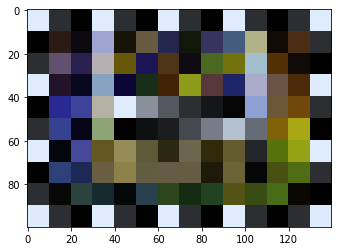

In [266]:
i += 1
print(i)
#colorsXYZ = np.roll(colorsXYZ, -1, axis=0)
p = get_palette(colorsXYZ, (14, 10))
p = np.transpose(p, axes=(1,0,2))
plt.imshow(p / np.amax(p))

In [265]:
np.transpose?

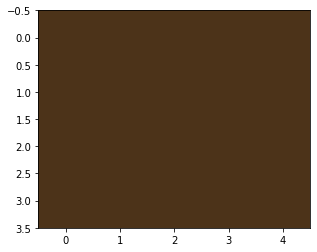

In [179]:
a = np.zeros((5, 4, 3))
a[:, :] = [0.3, 0.2, 0.1]
plt.imshow(np.reshape(a, (4, 5, 3)))

In [73]:
a = np.array([[1,2], [2,3], [3, 4], [4, 5]])
np.roll(a, 1, axis=0)

array([[4, 5],
       [1, 2],
       [2, 3],
       [3, 4]])